In [1]:
# ============================================
# Cell 1 – Imports & Config
# ============================================
import os
import random
from dataclasses import dataclass
import math
import warnings

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

os.makedirs("../models", exist_ok=True)

@dataclass
class CFG:
    data_root: str = "../data/Train_Cropped"   # folder: subfolder per mahasiswa

    img_size: int = 224
    batch_size: int = 16
    num_workers: int = 0

    epochs: int = 30
    lr: float = 1e-4
    weight_decay: float = 1e-4
    label_smoothing: float = 0.1   # ArcFace biasanya tanpa smoothing

    # ArcFace hyperparams
    arc_s: float = 25.0
    arc_m: float = 0.10            # 0.3 biasanya lebih stabil di dataset kecil

    val_ratio: float = 0.2
    seed: int = 32


CFG = CFG()
print(CFG)


Using device: cuda
CFG(data_root='../data/Train_Cropped', img_size=224, batch_size=16, num_workers=0, epochs=30, lr=0.0001, weight_decay=0.0001, label_smoothing=0.1, arc_s=25.0, arc_m=0.1, val_ratio=0.2, seed=32)


d:\Perkuliahan\Sem 7\Pembelajaran Mendalam\Tubes 2\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ============================================
# Cell 2 – Fix Seed
# ============================================
def set_seed(seed: int = 32):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(CFG.seed)
print("Seed set to:", CFG.seed)


Seed set to: 32


In [3]:
# ============================================
# Cell 3 – Dataset Scan, Stratified Split, Transforms
# ============================================
class FaceDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform is not None:
            img = self.transform(img)

        return img, label


def scan_dataset(root_dir):
    image_paths = []
    labels = []

    classes = sorted(os.listdir(root_dir))
    classes = [c for c in classes if os.path.isdir(os.path.join(root_dir, c))]
    label_map = {cls_name: i for i, cls_name in enumerate(classes)}

    for cls in classes:
        cls_dir = os.path.join(root_dir, cls)
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith((".jpg", ".jpeg", ".png", ".webp")):
                fpath = os.path.join(cls_dir, fname)
                image_paths.append(fpath)
                labels.append(label_map[cls])

    print("Total classes:", len(classes))
    print("Total images :", len(image_paths))
    return image_paths, labels, label_map


def stratified_split(paths, labels, val_ratio=0.2, seed=42):
    random.seed(seed)
    label_to_indices = {}

    for i, lbl in enumerate(labels):
        label_to_indices.setdefault(lbl, []).append(i)

    train_idx, val_idx = [], []
    for lbl, idxs in label_to_indices.items():
        random.shuffle(idxs)
        n_val = max(1, int(len(idxs) * val_ratio))
        val_idx.extend(idxs[:n_val])
        train_idx.extend(idxs[n_val:])

    train_paths = [paths[i] for i in train_idx]
    train_labels = [labels[i] for i in train_idx]
    val_paths = [paths[i] for i in val_idx]
    val_labels = [labels[i] for i in val_idx]

    print("Train samples:", len(train_paths))
    print("Val samples  :", len(val_paths))
    return train_paths, train_labels, val_paths, val_labels


# --- scan + split ---
all_paths, all_labels, label_map = scan_dataset(CFG.data_root)
train_paths, train_labels, val_paths, val_labels = stratified_split(
    all_paths, all_labels, CFG.val_ratio, CFG.seed
)

# --- transforms ---
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomApply([
        transforms.RandomAffine(
            degrees=8,
            translate=(0.05, 0.05),
            scale=(0.95, 1.05),
        )
    ], p=0.7),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4)
    ], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_tf = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

train_ds = FaceDataset(train_paths, train_labels, transform=train_tf)
val_ds = FaceDataset(val_paths, val_labels, transform=val_tf)

train_loader = DataLoader(
    train_ds,
    batch_size=CFG.batch_size,
    shuffle=True,
    num_workers=CFG.num_workers,
)

val_loader = DataLoader(
    val_ds,
    batch_size=CFG.batch_size,
    shuffle=False,
    num_workers=CFG.num_workers,
)

num_classes = len(label_map)
print("Final num_classes:", num_classes)


Total classes: 70
Total images : 283
Train samples: 213
Val samples  : 70
Final num_classes: 70


In [4]:
# ============================================
# Cell 4 – ArcFace (ArcMarginProduct)
# ============================================
class ArcMarginProduct(nn.Module):
    """
    ArcFace: cos(theta + m) dengan scaling s.
    input:  (B, in_features)  -> embedding
    label:  (B,)              -> class index
    output: (B, out_features) -> logits untuk CrossEntropy
    """
    def __init__(
        self,
        in_features: int,
        out_features: int,
        s: float = 25.0,
        m: float = 0.10,
        easy_margin: bool = False,
    ):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m

        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # normalize embedding dan weight
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))  # (B, C)
        sine = torch.sqrt(1.0 - torch.clamp(cosine.pow(2), 0.0, 1.0))

        phi = cosine * self.cos_m - sine * self.sin_m  # cos(theta + m)

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1), 1.0)

        # ganti only target logit dengan phi, others tetap cosine
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output


In [5]:
# ============================================
# Cell 5 – ResNet50 + ArcFace Model (Transfer Learning)
# ============================================
class ResNet50ArcFace(nn.Module):
    def __init__(self, num_classes: int, embedding_dim: int = 512,
                 s: float = 30.0, m: float = 0.30):
        super().__init__()

        weights = models.ResNet50_Weights.IMAGENET1K_V1
        backbone = models.resnet50(weights=weights)

        # Ambil feature dim sebelum fc
        in_features = backbone.fc.in_features  # 2048

        # Backbone tanpa fc
        backbone.fc = nn.Identity()

        # Optional fine-tuning:
        # freeze semua dulu
        for p in backbone.parameters():
            p.requires_grad = False

        for name, p in backbone.named_parameters():
            if "layer3" in name or "layer4" in name:
                p.requires_grad = True


        self.backbone = backbone
        self.embedding = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, embedding_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
        )
        self.arc_margin = ArcMarginProduct(
            in_features=embedding_dim,
            out_features=num_classes,
            s=s,
            m=m,
            easy_margin=False,
        )

    def forward(self, x, labels=None):
        feat = self.backbone(x)       # (B, 2048)
        emb = self.embedding(feat)    # (B, 512)
        emb = F.normalize(emb, dim=1)

        if labels is None:
            # inference mode: logits tanpa margin (pure cosine * s)
            logits = F.linear(F.normalize(emb), F.normalize(self.arc_margin.weight)) * self.arc_margin.s
        else:
            logits = self.arc_margin(emb, labels)

        return logits, emb


In [6]:
# ============================================
# Cell 6 – Init Model, Loss, Optimizer, Scheduler
# ============================================
from torch import amp

model = ResNet50ArcFace(
    num_classes=num_classes,
    embedding_dim=512,
    s=CFG.arc_s,
    m=CFG.arc_m,
).to(device)

print("Model created:")
print(model)

criterion = nn.CrossEntropyLoss(label_smoothing=CFG.label_smoothing)

trainable_params = [p for p in model.parameters() if p.requires_grad]
print("Trainable params:", sum(p.numel() for p in trainable_params))

optimizer = torch.optim.Adam(
    trainable_params,
    lr=CFG.lr,
    weight_decay=CFG.weight_decay,
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=CFG.epochs,
    eta_min=CFG.lr * 1e-2,
)


Model created:
ResNet50ArcFace(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample)

In [7]:
# ============================================
# Cell 7 – Train & Val Loop (ArcFace)
# ============================================
def train_one_epoch(model, loader):
    model.train()
    running_loss = 0.0
    all_preds, all_trues = [], []

    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs = imgs.to(device)
        labels = torch.as_tensor(labels, dtype=torch.long, device=device)

        optimizer.zero_grad()

        with amp.autocast(device_type="cuda", enabled=torch.cuda.is_available()):
            logits, _ = model(imgs, labels)   # pakai margin
            loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_trues.extend(labels.detach().cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_trues, all_preds)

    return epoch_loss, epoch_acc


def validate_one_epoch(model, loader):
    model.eval()
    running_loss = 0.0
    all_preds, all_trues = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Val", leave=False):
            imgs = imgs.to(device)
            labels = torch.as_tensor(labels, dtype=torch.long, device=device)

            with amp.autocast(device_type="cuda", enabled=torch.cuda.is_available()):
                logits, _ = model(imgs, labels=None)  # boleh tetap margin
                loss = criterion(logits, labels)

            running_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_trues.extend(labels.detach().cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_trues, all_preds)

    return epoch_loss, epoch_acc, np.array(all_trues), np.array(all_preds)


In [8]:
# ============================================
# Cell 8 – Main Training Loop
# ============================================

best_acc = 0.0
best_state = None

for epoch in range(1, CFG.epochs + 1):
    print(f"\n=== Epoch {epoch}/{CFG.epochs} ===")
    print(f"Current LR: {scheduler.get_last_lr()[0]:.6f}")

    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc, y_true, y_pred = validate_one_epoch(model, val_loader)

    scheduler.step()

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_state = model.state_dict()
        print(f"🔥 New best model! Val Acc = {best_acc:.4f}")

save_path = os.path.join("../models", "best_resnet50_arcface.pth")
torch.save(best_state, save_path)

print("\nTraining complete. Best Val Acc:", best_acc)
print(f"Model saved to: {save_path}")



=== Epoch 1/30 ===
Current LR: 0.000100


Train Loss: 6.8481 | Train Acc: 0.0000
Val   Loss: 3.8744 | Val   Acc: 0.1571
🔥 New best model! Val Acc = 0.1571

=== Epoch 2/30 ===
Current LR: 0.000100


Train Loss: 6.0979 | Train Acc: 0.0000
Val   Loss: 3.3508 | Val   Acc: 0.3286
🔥 New best model! Val Acc = 0.3286

=== Epoch 3/30 ===
Current LR: 0.000099


Train Loss: 5.6807 | Train Acc: 0.0141
Val   Loss: 2.8611 | Val   Acc: 0.5000
🔥 New best model! Val Acc = 0.5000

=== Epoch 4/30 ===
Current LR: 0.000098


Train Loss: 5.1067 | Train Acc: 0.0282
Val   Loss: 2.4547 | Val   Acc: 0.5571
🔥 New best model! Val Acc = 0.5571

=== Epoch 5/30 ===
Current LR: 0.000096


Train Loss: 4.6696 | Train Acc: 0.0563
Val   Loss: 2.1703 | Val   Acc: 0.5714
🔥 New best model! Val Acc = 0.5714

=== Epoch 6/30 ===
Current LR: 0.000093


Train Loss: 4.1542 | Train Acc: 0.1408
Val   Loss: 1.9505 | Val   Acc: 0.6571
🔥 New best model! Val Acc = 0.6571

=== Epoch 7/30 ===
Current LR: 0.000091


Train Loss: 3.6914 | Train Acc: 0.1596
Val   Loss: 1.8568 | Val   Acc: 0.6714
🔥 New best model! Val Acc = 0.6714

=== Epoch 8/30 ===
Current LR: 0.000087


Train Loss: 3.2870 | Train Acc: 0.3099
Val   Loss: 1.7586 | Val   Acc: 0.7286
🔥 New best model! Val Acc = 0.7286

=== Epoch 9/30 ===
Current LR: 0.000084


Train Loss: 2.9050 | Train Acc: 0.3615
Val   Loss: 1.7141 | Val   Acc: 0.6857

=== Epoch 10/30 ===
Current LR: 0.000080


Train Loss: 2.5146 | Train Acc: 0.4883
Val   Loss: 1.7304 | Val   Acc: 0.6857

=== Epoch 11/30 ===
Current LR: 0.000075


Train Loss: 2.2244 | Train Acc: 0.5962
Val   Loss: 1.7132 | Val   Acc: 0.7286

=== Epoch 12/30 ===
Current LR: 0.000071


Train Loss: 2.0607 | Train Acc: 0.6714
Val   Loss: 1.7139 | Val   Acc: 0.7286

=== Epoch 13/30 ===
Current LR: 0.000066


Train Loss: 1.8292 | Train Acc: 0.8122
Val   Loss: 1.6510 | Val   Acc: 0.7429
🔥 New best model! Val Acc = 0.7429

=== Epoch 14/30 ===
Current LR: 0.000061


Train Loss: 1.6382 | Train Acc: 0.8404
Val   Loss: 1.6695 | Val   Acc: 0.7571
🔥 New best model! Val Acc = 0.7571

=== Epoch 15/30 ===
Current LR: 0.000056


Train Loss: 1.5733 | Train Acc: 0.8732
Val   Loss: 1.6498 | Val   Acc: 0.7429

=== Epoch 16/30 ===
Current LR: 0.000051


Train Loss: 1.4327 | Train Acc: 0.8967
Val   Loss: 1.6842 | Val   Acc: 0.7571

=== Epoch 17/30 ===
Current LR: 0.000045


Train Loss: 1.3441 | Train Acc: 0.9061
Val   Loss: 1.7044 | Val   Acc: 0.7714
🔥 New best model! Val Acc = 0.7714

=== Epoch 18/30 ===
Current LR: 0.000040


Train Loss: 1.2472 | Train Acc: 0.9437
Val   Loss: 1.6825 | Val   Acc: 0.8143
🔥 New best model! Val Acc = 0.8143

=== Epoch 19/30 ===
Current LR: 0.000035


Train Loss: 1.2971 | Train Acc: 0.9343
Val   Loss: 1.6444 | Val   Acc: 0.8000

=== Epoch 20/30 ===
Current LR: 0.000030


Train Loss: 1.1920 | Train Acc: 0.9624
Val   Loss: 1.6398 | Val   Acc: 0.8143

=== Epoch 21/30 ===
Current LR: 0.000026


Train Loss: 1.1482 | Train Acc: 0.9812
Val   Loss: 1.6695 | Val   Acc: 0.8143

=== Epoch 22/30 ===
Current LR: 0.000021


Train Loss: 1.1494 | Train Acc: 0.9718
Val   Loss: 1.6398 | Val   Acc: 0.8286
🔥 New best model! Val Acc = 0.8286

=== Epoch 23/30 ===
Current LR: 0.000017


Train Loss: 1.1419 | Train Acc: 0.9671
Val   Loss: 1.6536 | Val   Acc: 0.8286

=== Epoch 24/30 ===
Current LR: 0.000014


Train Loss: 1.1174 | Train Acc: 0.9812
Val   Loss: 1.6811 | Val   Acc: 0.8286

=== Epoch 25/30 ===
Current LR: 0.000010


Train Loss: 1.0774 | Train Acc: 0.9812
Val   Loss: 1.6778 | Val   Acc: 0.8143

=== Epoch 26/30 ===
Current LR: 0.000008


Train Loss: 1.0367 | Train Acc: 0.9953
Val   Loss: 1.6647 | Val   Acc: 0.8286

=== Epoch 27/30 ===
Current LR: 0.000005


Train Loss: 1.0538 | Train Acc: 0.9765
Val   Loss: 1.6781 | Val   Acc: 0.8143

=== Epoch 28/30 ===
Current LR: 0.000003


Train Loss: 1.0468 | Train Acc: 0.9859
Val   Loss: 1.6842 | Val   Acc: 0.8286

=== Epoch 29/30 ===
Current LR: 0.000002


Train Loss: 1.0385 | Train Acc: 0.9906
Val   Loss: 1.6678 | Val   Acc: 0.8143

=== Epoch 30/30 ===
Current LR: 0.000001


Train Loss: 1.0891 | Train Acc: 0.9953
Val   Loss: 1.6757 | Val   Acc: 0.8000

Training complete. Best Val Acc: 0.8285714285714286
Model saved to: ../models\best_resnet50_arcface.pth


In [9]:
# ============================================
# Cell 9 – Final Evaluation (Confusion Matrix + Report)
# ============================================

best_model_path = os.path.join("../models", "best_resnet50_arcface.pth")

model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

all_true = []
all_pred = []

with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Final Eval", leave=False):
        imgs = imgs.to(device)
        labels = torch.as_tensor(labels, dtype=torch.long, device=device)

        # Di eval, kita pakai logits tanpa margin (lebih fair)
        logits, _ = model(imgs, labels=None)
        preds = logits.argmax(1)

        all_true.extend(labels.cpu().numpy())
        all_pred.extend(preds.cpu().numpy())

acc = accuracy_score(all_true, all_pred)
cm = confusion_matrix(all_true, all_pred)
report = classification_report(all_true, all_pred)

print("Final Val Accuracy:", acc)
print("Confusion matrix shape:", cm.shape)
print(report)


Final Val Accuracy: 0.8
Confusion matrix shape: (70, 70)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00         1
           2       0.50      1.00      0.67         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       0.00      0.00      0.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         1
          16       1.00 

Preview Predictions:  80%|████████  | 4/5 [00:00<00:00,  7.11it/s]


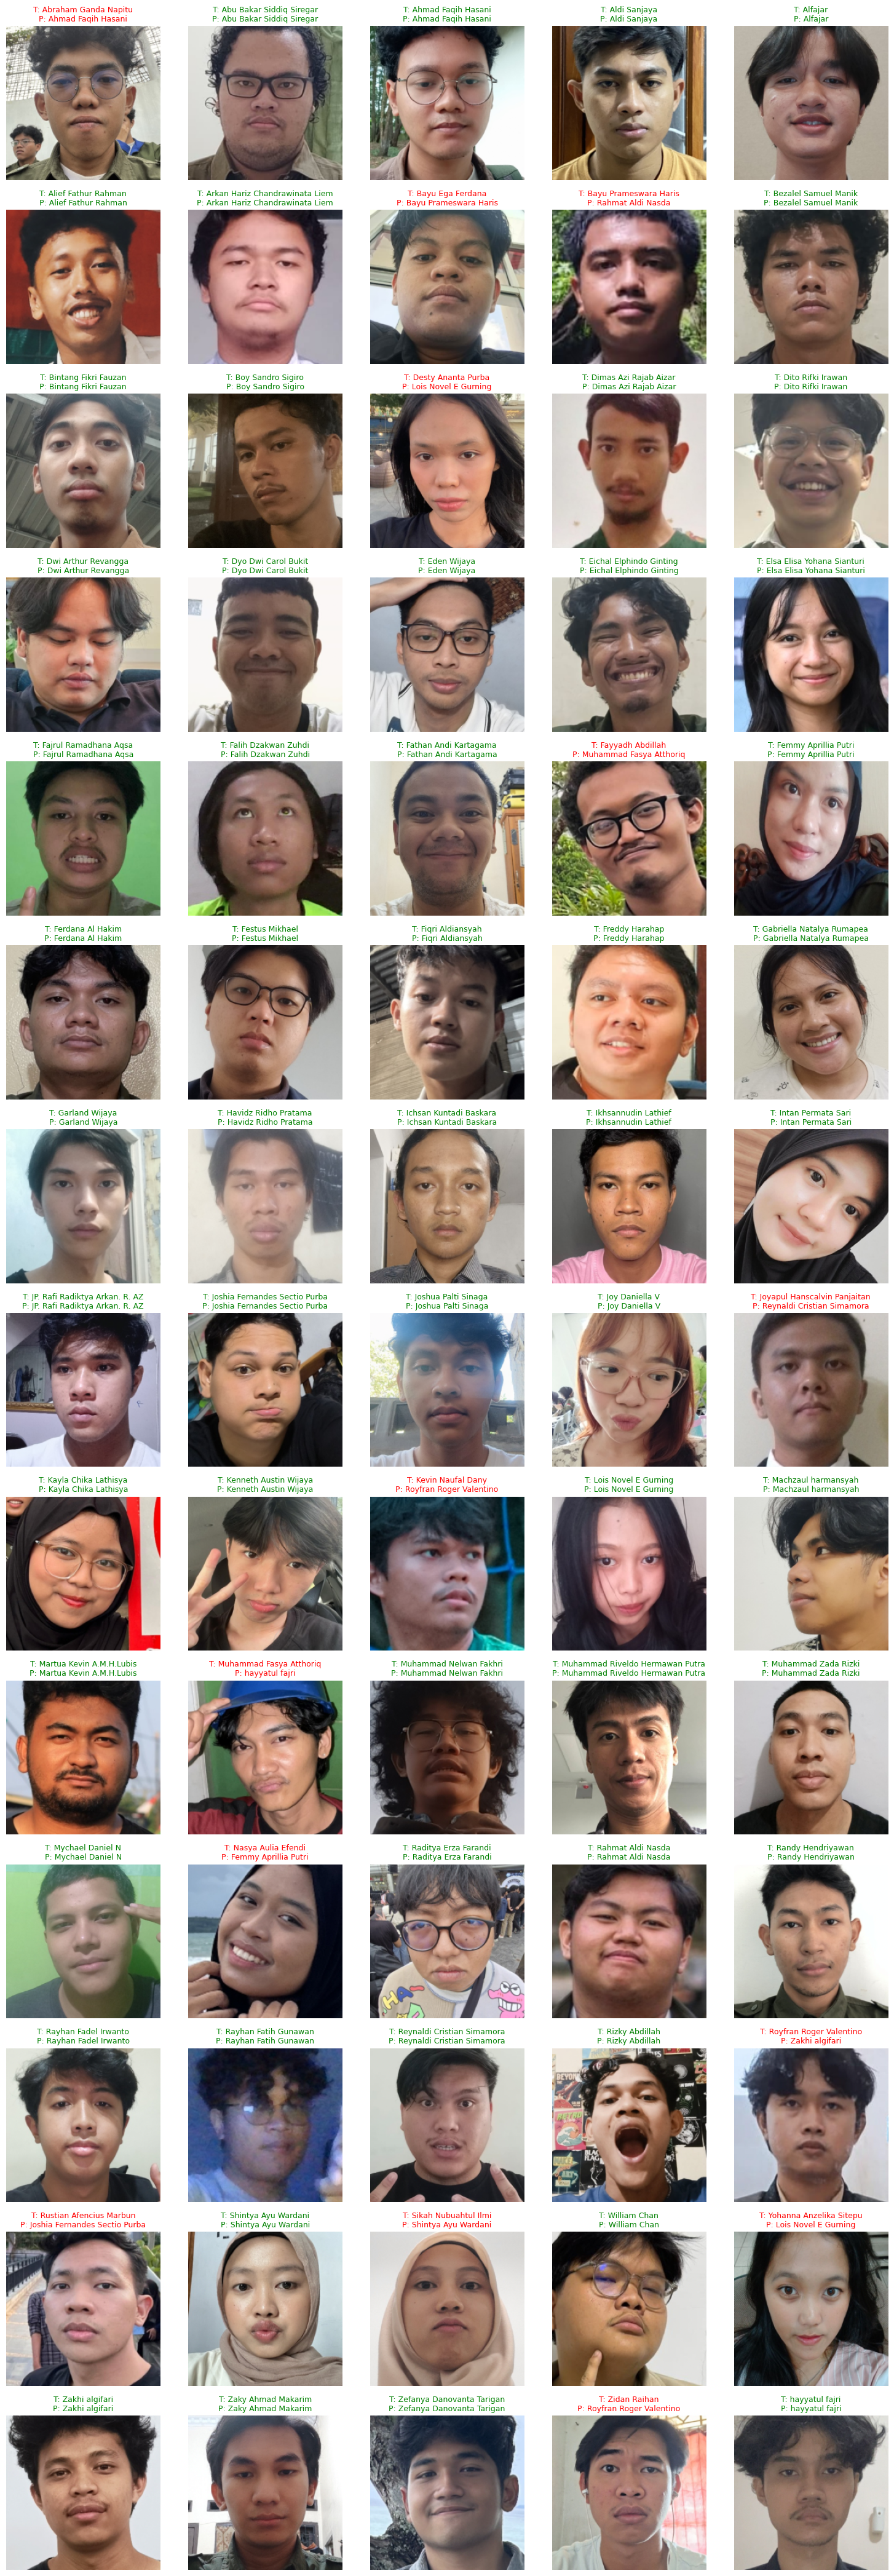

Displayed 70 images.


In [10]:
# ======================================================
# Cell 10 – Prediction Visualization
# ======================================================
import matplotlib.pyplot as plt
import numpy as np
import torch

val_dataset = val_loader.dataset
idx_to_class = {v: k for k, v in label_map.items()}

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def denormalize(img_t: torch.Tensor) -> np.ndarray:
    img = img_t.cpu() * IMAGENET_STD + IMAGENET_MEAN
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    return img


# --- Grid settings ---
ROWS = 14
COLS = 5
MAX_SHOW = 70 

model.eval()
images_shown = 0

with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Preview Predictions"):

        imgs = imgs.to(device)
        labels = labels.to(device)

        logits, _ = model(imgs, labels=None)
        preds = logits.argmax(1)

        for i in range(len(imgs)):

            # Plot hanya saat batch pertama sampai batas
            if images_shown == 0:
                fig, axes = plt.subplots(
                    ROWS, COLS, figsize=(COLS * 3, ROWS * 3)
                )

            r = (images_shown // COLS)
            c = (images_shown % COLS)
            ax = axes[r, c]

            # Denormalize
            img_np = denormalize(imgs[i])

            true_idx = labels[i].item()
            pred_idx = preds[i].item()

            true_name = idx_to_class[true_idx]
            pred_name = idx_to_class[pred_idx]

            correct = (true_idx == pred_idx)

            ax.imshow(img_np)
            ax.set_title(
                f"T: {true_name}\nP: {pred_name}",
                fontsize=9,
                color=("green" if correct else "red"),
            )
            ax.axis("off")

            # Border color
            for spine in ax.spines.values():
                spine.set_edgecolor("green" if correct else "red")
                spine.set_linewidth(3)

            images_shown += 1

            if images_shown >= MAX_SHOW:
                break

        if images_shown >= MAX_SHOW:
            break

plt.tight_layout()
plt.show()

print(f"Displayed {images_shown} images.")


In [ ]:
# ============================================
# Cell X – Save label_map ke JSON
# ============================================
import json

save_path = os.path.join("../models", "label_map.json")

with open(save_path, "w", encoding="utf-8") as f:
    json.dump(label_map, f, ensure_ascii=False, indent=2)

print(f"Saved label_map.json to {save_path} with {len(label_map)} classes")

FileNotFoundError: [Errno 2] No such file or directory: 'models\\label_map.json'